In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib import rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt


#맥에서 한글 안깨지게
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("../re_data_processed/train.csv") # 각자 경로에 맞게 수정
df_holidays = pd.read_csv("../holidays_2023_2025.csv") # 각자 경로에 맞게 수정

# 연, 월, 일 col 생성
df['영업일자'] = pd.to_datetime(df['영업일자'])
df['연'] = df['영업일자'].dt.year
df['월'] = df['영업일자'].dt.month
df['일'] = df['영업일자'].dt.day
# 영업장, 메뉴명 col 생성
df[['영업장', '메뉴명']] = df['영업장명_메뉴명'].str.split('_', expand=True)
# 요일 col 생성
df['요일'] = df['영업일자'].dt.dayofweek.map({
    0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'
})
# 공휴일 col 생성
df_holidays["locdate"] = pd.to_datetime(df_holidays["locdate"])
holiday_dates = set(df_holidays['locdate'])
df['is_holiday'] = df['영업일자'].isin(holiday_dates).astype(int)


/var/folders/cn/h70gsvwd2pd2z7ks4_gdxb4w0000gn/T/ipykernel_31169/562194822.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hall['요일'] = pd.Categorical(df_hall['요일'], categories=weekday_order, ordered=True)


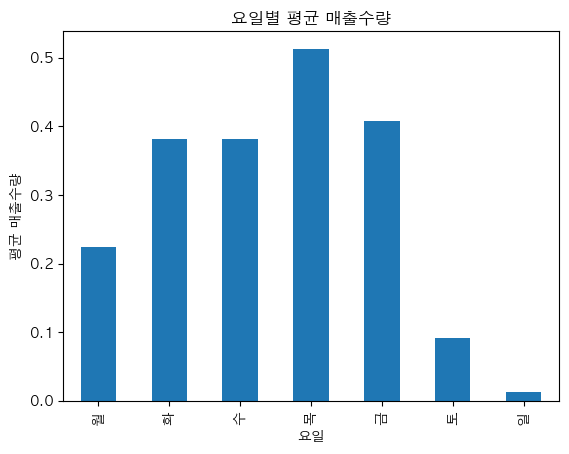

In [67]:
df_hall = df.loc[df['영업장명_메뉴명'] == '연회장_OPUS 2'] # 영업장명_메뉴명 바꿔주면서 확인

# 요일 순서 정의
weekday_order = ['월', '화', '수', '목', '금', '토', '일']

# 요일 컬럼을 Categorical 로 변환
df_hall['요일'] = pd.Categorical(df_hall['요일'], categories=weekday_order, ordered=True)

# 요일별 평균 (매출 있는 날만)
df_hall.groupby('요일')['매출수량'].mean().plot(
    kind='bar', title='요일별 평균 매출수량'
)
plt.ylabel("평균 매출수량")
plt.show()

In [68]:
# 요일별 표준편차 계산 후 출력
std_table = df_hall.groupby('요일')['매출수량'].std().reset_index()
std_table.columns = ['요일', '표준편차']
print(std_table)

  요일      표준편차
0  월  0.419482
1  화  0.515548
2  수  0.540792
3  목  0.599854
4  금  0.520964
5  토  0.291096
6  일  0.114708


In [69]:
# 요일 순서 유지용
weekday_order = ['월', '화', '수', '목', '금', '토', '일']

# (1) 요일별 평균
wk_mean = (
    df_hall.groupby('요일', observed=True)['매출수량']
           .mean()
           .reindex(weekday_order)
)

# (2) "해당 메뉴의 전체 평균" (요일 무시)
overall_mean = df_hall['매출수량'].mean()

# (3) 편차 = 요일별 평균 - 전체 평균  (± 방향 보존)
dev = wk_mean - overall_mean   # pd.Series index=요일

# (4) 0~1 가중치로 스케일링 (min-max)
min_v, max_v = dev.min(), dev.max()
if np.isclose(max_v, min_v):   # 모든 요일이 같아서 분모=0 방지
    weight = pd.Series(1.0, index=dev.index)  # 전부 동일 가중치
else:
    weight = 1 + (dev - min_v) / (max_v - min_v)

# (5) 테이블 정리
weekday_weight = pd.DataFrame({
    '요일': dev.index,
    '평균편차': dev.values,     # ± 방향 정보 유지
    '요일가중치': weight.values  # 0~1 스케일
})

print(weekday_weight)

  요일      평균편차     요일가중치
0  월 -0.063910  1.421053
1  화  0.093985  1.736842
2  수  0.093985  1.736842
3  목  0.225564  2.000000
4  금  0.120301  1.789474
5  토 -0.195489  1.157895
6  일 -0.274436  1.000000


is_holiday
평일    0.304781
휴일    0.000000
Name: 매출수량, dtype: float64


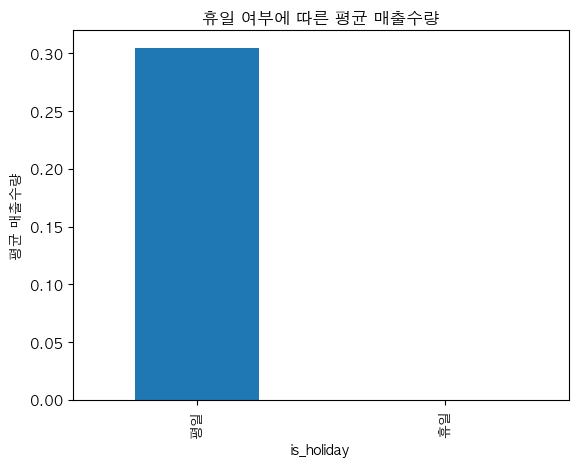

In [70]:
# 휴일 여부에 따른 평균 매출수량
holiday_mean = (
    df_hall.groupby('is_holiday')['매출수량']
    .mean()
    .rename({0: '평일', 1: '휴일'})
)

print(holiday_mean)

# 시각화
holiday_mean.plot(kind='bar', title='휴일 여부에 따른 평균 매출수량')
plt.ylabel("평균 매출수량")
plt.show()

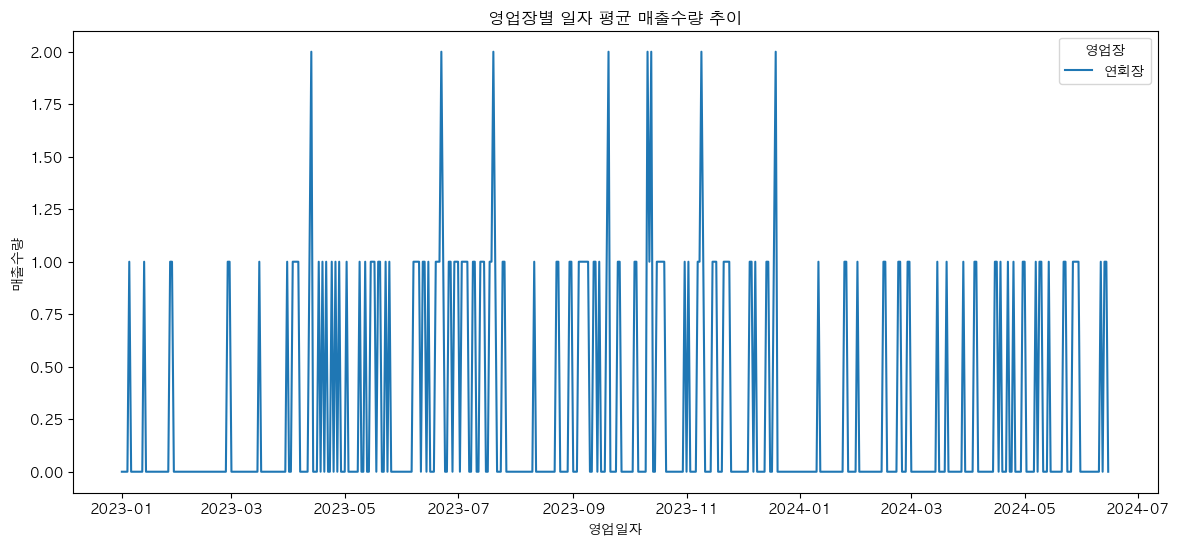

In [71]:
daily_shop = df_hall.groupby(['영업일자', '영업장'])['매출수량'].mean().reset_index()

# 매출이 있는 날만 필터링

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_shop, x='영업일자', y='매출수량', hue='영업장')
plt.title('영업장별 일자 평균 매출수량 추이')
plt.show()